# Tutorial: TripletLoss for re-identification using FastAI v2

This tutorial demonstrates the use of the `TripleLoss` loss function in FastAI v2 (running over Pytorch). TripletLoss is one of the leading ways to match an image (or sound or other signal) with a large database of images, even if there are very few matches for that particular input. Joint-embedding networks (aka Twin or Siamese networks) are a common alternative for this "low k-shot" challenge. According to [that article I read](tk), triplet loss outperformed twin networks in all of the tk studies where both approaches were tried. Another option for re-identification is Scale Invariant Feature Transform (SIFT) which is implemented in OpenCV. I haven't seen any papers comparing SIFT and statistical ML techniques in real-world tasks. 

The tutorial walks you through:

- Creating the necessary conda environment
- Downloading and expanding the MNIST dataset of handwritten digits
- Creating and training a model using triplet loss
- Applying this model to a few images of a new glyph (a hand-drawn star)
- Finding the closest neighbors to the new images
- Visualizing that the model tightly clusters the new glyph
- Demonstrating that the model can be used for re-identification of the new glyph

MNIST is an easy problem for modern statistical ML, with relatively small data and a small input size. This makes it a good candidate for a tutorial. I will try to highlight the places where you'll need to alter parameters when faced with a more realistic task, like animal re-identification. 

The code assumes that you have a CUDA-accelerated GPU for training and inferencing. The tutorial runs quickly on a 2080 (about 30 seconds per epoch during training, about 20ms to inference) but runs _much_ slower on a mobile GPU like a GeForce GTX 1650 (30 minutes per epoch on my Surface Book 3). I assume that porting it to CPU wouldn't be difficult, but I think it would be quite slow. If you don't have a local GPU, I'd suggest using a GPU-powered cloud compute resource, such as Azure ML. (Let me know if you'd like to see a tutorial on running this in Azure ML.) 

## The problem of re-identification

Our photo libraries are filled with images of our friends and family. A machine learning model that focuses on "classification" can successfully tell us that we have lots of photos of "smiling man" or "smiling woman." Such models will not, generally, tell us which photos are of Uncle Al and Aunt Betty. _That_ task -- re-identifying individuals -- is a different problem and requires different approaches.

Beyond identifying Uncle Al and Aunt Betty in a photo library, re-identification is a common problem for wildlife biologists. Many species have photographic catalogs taken over years and decades, and many species have some distinctive features that can be used to identify individuals. 

## Create the Python environment 

I developed this tutorial on Ubuntu 20.04, Cuda 10.2, PyTorch 1.7, FastAI 2.3. I have to admit that the rigmarole of exactly recreating a GPU-enabled virtual environment is a little beyond me, but I _think_ you have to install CUDA manually and then when you run the `conda create` command below, I _think_ it will download properly-configured versions of the various libraries. 

Prequisites: 
1. [Install conda](tk) 
1. [Install CUDA](tk)

1. Clone this repo and change into the directory.
1. Create the environment:
    ```bash
    conda create -f 'conda_environment.yml'
    ```
1. Activate the environment for use with:
   ```bash
   conda activate fastai
   ```
1. Confirm the environment by running:
   ```bash
   python .\versions.py
   ```
Which should result in something similar to:
```bash
Pytorch : 1.7.0, FastAI : 2.3.1, CUDA? : True
```

The environment also installs Jupyter. You may need to restart your terminal session to have the `jupyter` in your path. Run:

```bash
jupyter notebook TripletLossTutorial.ipynb
```

and continue from there.

# Tutorial: TripletLoss for re-identification using FastAI v2

**If you have not done so, please see [README.md](readme.md) for instructions on creating the Python environment for this tutorial.**

## Import packages

Nothing surprising here, I think. To visualize the output, we're going to use scikit-learn's TSNE implementation. I've heard this isn't the fastest TSNE, but for 10K datapoints and a limited number of dimensions, it's fine. 

In [1]:
from fastai.vision.all import *

import torch
import torch.nn as nn
from loss_functions.triplet_loss import TripletLoss
from scipy import spatial

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid

## Confirm versions and CUDA

This is just to confirm you're running GPU-accelerated. If you don't have a GPU, I think training will be very slow. (Let me know if I'm wrong!)

In [3]:
import fastai
fastai.__version__

'2.7.9'

In [4]:
torch.cuda.is_available()

True

In [5]:
device = 0
torch.cuda.set_device(device)

## Setup the training data

The training data for this tutorial is the MNIST dataset of hand-written digits 0-9. The dataset contains 10K PNG images of size 28x28. The PNGs are 3-channel, but all the pixels are grayscale. Dear ol' MNIST.

IMAGE TK 

Now, you're probably used to MNIST as a dataset for _image classification_: "To which of the trained-on categories ('0'...'9') does this query image most likely belong?" But for this tutorial, we're using it to learn "glyph re-identification." Our acid test will be seeing if images of a glyph not seen during training (a star) can be re-identified with very few samples (aka "low shot").

`URLs.MNIST`, `untar_data()`, and `get_image_files()` are from the `fastai.basics` module. The following cell will download, if necessary, the MNIST dataset and unpack it. By default, the data will be stored in `~/.fastai/data`. (It's a good idea to keep track of the size of that directory when fooling around with FastAI! Some of the datasets are _big_!).

In [6]:
mnist = untar_data(URLs.MNIST)
fnames = get_image_files(mnist)

Now, `~/.fastai/data/mnist_ping/` contains `testing/` and `training/` directories, which in turn have `0/`, `1/`, `2/`, etc. subdirectories. FastAI v2's `ImageDataLoaders` class can process this typical directory structure and take care of the boilerplate of testing vs. training sets, loading and transforming the images appropriately for processing, etc.

In [7]:
# The proper label for an image is the name of the directory it's in. e.g., "1" is the proper label for `1/1.png`
def label_func(x): return x.parent.name

dls = ImageDataLoaders.from_path_func(mnist, fnames, label_func)

The output of a TripletLoss-based model is an embedding (a vector representing a point in a high-dimensional space). The goal is that each of the dimensions in this embedding space represents a feature in the "how to tell individuals of this class apart" solution space. The distance between any two embeddings 

After training, the model generates embedding values for a query image. 

In a real-world animal re-identification model, this might be on the order of 128. In the case of MNIST, we can get fine results with just a few output features.

In [8]:
# output_embedding_length = 128
output_embedding_length = 32

To create a TripletLoss-based embedding, we'll start with a standard Convolutional Neural Network using our recently created `dls` `ImageDataLoaders` object, the ResNet34 architecture, and FastAI's (PyTorch's?) TripletLoss function. 

In [9]:
learn = vision_learner(dls, resnet34, metrics=[], loss_func=TripletLoss(device))

/home/jav/miniconda3/envs/fastai.v5/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jav/miniconda3/envs/fastai.v5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# learn.model[0] contains the network's "body", and model[1] just the head:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

We want to replace the classification head of the ResNet34 architecture with an embedding output.  The `L2_norm` class normalizes the values to the range $ (0.0,1.0) $. 

In [11]:
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [12]:
layers = learn.model[1]
learn.model[1] = nn.Sequential(
    layers[0], layers[1], layers[2], layers[3], layers[4], layers[5], layers[6], layers[7], 
    nn.Linear(in_features=512, out_features=output_embedding_length, bias=False), L2_norm()
).to(device)
    

In [13]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=32, bias=False)
  (9): L2_norm()
)

We now have a model configured for TripletLoss. What happens behind the scene when this model is trained? 

Basically, the training loop will grab 3 images: a `target` image, a `positive` image, and a `negative` image. The `target` and `positive` are in the same class ('1', '2', '3', etc.) while the `negative` image is in a different class. The basic goal of training is to find weights such that `target` and `positive` have embedding values that are near other while `target` and `negative` have embedding values that are far from each other. 

If you think about that, _most_ triplets are going to end up being 'easy'; any two random '9's are likely to share several features, while a randomly selected not-9 is unlikely to be "oh, yeah, that could be a 9." So training with just-random triplets is less efficient than training with 'hard' triplets. In a hard triplet, the `positive` and `negative` are as close as possible to the dividing line in "tell glyphs apart" embedding space. In an ideal 'hard' triplet with a `target` in class '9', the 'positive' is a '9' image that's close in appearance to a '7' image that could be mistaken for a '9'. Finding hard triplets and using them for training is somewhere between "valuable" and "essential" in real-world re-identification tasks. "Triplet mining" is outside the scope of this tutorial, but you can read more about it [here](tk). 

## Training

FastAI's `lr_find()` function does a quick sweep of learning rates. Typically, a good learning rate is one where the slope of the `lr_find()` graph is steepest.

SuggestedLRs(valley=0.009120108559727669)

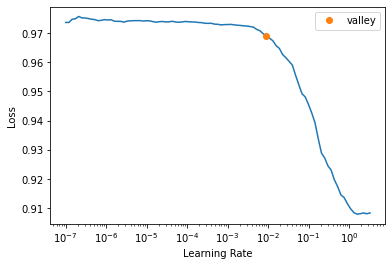

In [14]:
learn.lr_find()

For tutorial purposes and because MNIST is pretty easy, we're going to use a fast learning rate and few epochs. Real-world data sets won't be so kind!

In [15]:
epochs = 20
model_name = f'{epochs}_epochs_{output_embedding_length}_features'

try:
    learn = learn.load(model_name)
except:
    lr = 0.1
    epochs = 20
    learn.fit_one_cycle(epochs, slice(lr))
    learn.save(model_name)

epoch,train_loss,valid_loss,time
0,0.230185,0.153539,00:33
1,0.133782,0.131332,00:32
2,0.117544,0.173046,00:34
3,0.107722,0.086296,00:34
4,0.099810,0.091931,00:33
5,0.085169,0.077105,00:33
6,0.078655,0.081761,00:33
7,0.082691,0.098803,00:33
8,0.047856,0.061368,00:33
9,0.051574,0.055845,00:34


## Inferencing

To get the output embedding of a `query` image, we just use `learn.predict()` on our trained `Learner: 

In [16]:
query_img = PILImage.create('stars/Star1.png')
result = learn.predict(query_img)
query_fingerprint = result[1].numpy()
print(query_fingerprint)

[-0.4385764   0.07380641  0.23816751  0.29184356 -0.14723992  0.34137195
  0.06991758  0.33740816  0.09130197 -0.22511393  0.21159591  0.10746336
  0.16765437  0.21437302  0.12018973 -0.16545856 -0.18934958 -0.07480964
 -0.08150642 -0.17008734 -0.12432582 -0.08482609 -0.01266793 -0.02727649
  0.11497439  0.17786284 -0.03590712  0.02044249  0.03340663  0.02261158
  0.08458877 -0.12734443]


### Fingerprinting the exemplars

Create the database to which we will compare `query_fingerprint`:    

In [17]:
fnames = list(Path(mnist/'testing').rglob('*.png'))
len(fnames)

10000

In [18]:
fnames[0]

Path('/home/jav/.fastai/data/mnist_png/testing/4/7818.png')

In [19]:
def fingerprint_all(fnames):
    fingerprints = {}
    for f in progress_bar(fnames):
        category = label_func(f)
        img = PILImage.create(f)
        with learn.no_bar():
            result = learn.predict(img)
        fingerprint = result[1].numpy()
        fingerprints[(category,f)] = fingerprint
    return fingerprints

fingerprint_db = fingerprint_all(fnames)

## Nearest k-neighbors

Because our embedding values are normalized, finding the nearest k-neighbors is trivial:

In [20]:
# Find k nearest neighbour using cosine similarity. Normalized vectors, so easy...
def find_k_nearest_neighbors(vectors,vec,k):
    dist_arr = np.matmul(vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]


In [21]:
## Put it together

def best_match_mnist(fingerprint_db, fingerprint, k, display_data=False):
    fps = list(fingerprint_db.values())
    keys = list(fingerprint_db.keys())
    match_indices = find_k_nearest_neighbors(fps,fingerprint,k)
    for i in match_indices:
        match_fp = fps[i]
        distance = spatial.distance.cosine(match_fp, fingerprint)
        if display_data:
            display(Image.open(keys[i][1]))    
            display([keys[i][0], keys[i][1], distance, match_fp])
        yield (keys[i], distance)
        
list(best_match_mnist(fingerprint_db, query_fingerprint, 10, display_data=True));

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5876.png'),
 0.03822958469390869,
 array([-3.68332297e-01,  1.58202797e-01,  2.95534283e-01,  2.31184542e-01,
        -1.78733289e-01,  3.77019674e-01,  1.26442909e-01,  3.05077612e-01,
         7.04605654e-02, -2.33200312e-01,  2.21860155e-01,  1.09218769e-01,
         1.93249613e-01,  2.20926225e-01,  1.08081222e-01, -2.30418533e-01,
        -2.20318958e-01, -8.47602636e-02, -5.90615310e-02, -1.71346053e-01,
        -7.63074979e-02,  3.74966156e-04,  6.62550181e-02, -1.17210075e-01,
         1.17863484e-01,  1.04648709e-01,  3.06050368e-02,  2.86547444e-03,
        -1.30512118e-02,  3.01726423e-02,  4.46750410e-02, -5.05277514e-02],
       dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/2111.png'),
 0.04001057147979736,
 array([-0.36306724,  0.13900602,  0.2915186 ,  0.22999087, -0.16271171,
         0.37451634,  0.12117532,  0.30122486,  0.05905059, -0.24575944,
         0.2301542 ,  0.12598327,  0.18955672,  0.2393089 ,  0.11471233,
        -0.25408018, -0.21603131, -0.07120273, -0.05722496, -0.16591428,
        -0.06492431, -0.00286971,  0.04813105, -0.1218137 ,  0.11783452,
         0.09741097,  0.03107424,  0.02289542, -0.02657417,  0.03526381,
         0.04927958, -0.04491814], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/6629.png'),
 0.04018741846084595,
 array([-0.37598267,  0.14729178,  0.29981396,  0.23184597, -0.17113245,
         0.3693326 ,  0.12197712,  0.29893762,  0.0649836 , -0.23279262,
         0.22444412,  0.11953775,  0.19433382,  0.23397318,  0.10269549,
        -0.23896007, -0.21337178, -0.08672515, -0.05094349, -0.16870372,
        -0.06659477,  0.00362819,  0.0638281 , -0.12545557,  0.12865227,
         0.0933653 ,  0.0260153 ,  0.00819198, -0.01368039,  0.03658072,
         0.04711308, -0.04478485], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/401.png'),
 0.04267317056655884,
 array([-0.3635762 ,  0.15103394,  0.30694067,  0.23331632, -0.16829519,
         0.36755362,  0.11850319,  0.29123622,  0.06036897, -0.2427889 ,
         0.22272967,  0.117998  ,  0.19722615,  0.23765899,  0.10490257,
        -0.24492508, -0.21673615, -0.06731602, -0.05699643, -0.1654917 ,
        -0.05789862, -0.00133317,  0.04790812, -0.13276196,  0.14030954,
         0.09052319,  0.03237328,  0.0209347 , -0.01486127,  0.03653141,
         0.05588738, -0.0459619 ], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/631.png'),
 0.04328185319900513,
 array([-0.35765868,  0.15655084,  0.2932479 ,  0.23065555, -0.1714703 ,
         0.37198526,  0.12562305,  0.30216062,  0.06489266, -0.23358652,
         0.23316738,  0.11417682,  0.194542  ,  0.234649  ,  0.11020373,
        -0.23875116, -0.2214867 , -0.07838724, -0.05085449, -0.16527662,
        -0.06611587,  0.00831954,  0.05939326, -0.12688471,  0.13511713,
         0.09956309,  0.03122707,  0.00056342, -0.02943123,  0.03529185,
         0.05423586, -0.04379964], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/2213.png'),
 0.043420612812042236,
 array([-0.36173356,  0.15118621,  0.29811877,  0.22328272, -0.17127284,
         0.37576228,  0.1278009 ,  0.2878798 ,  0.07162137, -0.23225948,
         0.23361638,  0.11763023,  0.19491744,  0.22889662,  0.10453572,
        -0.2426079 , -0.22669537, -0.06324654, -0.06669908, -0.18271776,
        -0.06520734,  0.01194281,  0.04815498, -0.12896037,  0.12580338,
         0.10066501,  0.04210657,  0.01241063, -0.01730939,  0.02693971,
         0.04445782, -0.05199178], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5075.png'),
 0.04345858097076416,
 array([-0.36603835,  0.13809067,  0.30036038,  0.22559561, -0.15871654,
         0.37045795,  0.11207646,  0.28772548,  0.06201591, -0.23874035,
         0.23705716,  0.13031502,  0.19684488,  0.23974243,  0.10817204,
        -0.2554767 , -0.21949022, -0.04996233, -0.06158025, -0.17326577,
        -0.0524784 , -0.00420228,  0.02706013, -0.13724124,  0.13671991,
         0.08337338,  0.02953451,  0.04146313, -0.01712115,  0.02942331,
         0.05245205, -0.04330927], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5041.png'),
 0.04408001899719238,
 array([-0.37792206,  0.14327739,  0.29588518,  0.22205108, -0.15390421,
         0.375913  ,  0.12836885,  0.28317535,  0.06273706, -0.24125488,
         0.23851702,  0.1158187 ,  0.19479631,  0.23465155,  0.08906908,
        -0.24843045, -0.21785651, -0.05798931, -0.06816064, -0.1762644 ,
        -0.0602752 ,  0.00266467,  0.04674225, -0.12965332,  0.13261664,
         0.09208895,  0.03854197,  0.01601067, -0.02715193,  0.03724685,
         0.04685879, -0.04149384], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/3674.png'),
 0.044481873512268066,
 array([-0.3735578 ,  0.13674317,  0.28267494,  0.22327714, -0.16084382,
         0.37290594,  0.12527774,  0.2872721 ,  0.05434507, -0.24710833,
         0.23781857,  0.12222282,  0.1894053 ,  0.24195391,  0.10637863,
        -0.25438133, -0.21751533, -0.06105465, -0.07418441, -0.17454109,
        -0.06548575,  0.00978926,  0.04441009, -0.12333474,  0.12435462,
         0.0965028 ,  0.05425693,  0.00577618, -0.04075005,  0.03111848,
         0.04606702, -0.04257673], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/4117.png'),
 0.045124828815460205,
 array([-0.35156298,  0.16355656,  0.30134732,  0.22667001, -0.17924194,
         0.37603086,  0.12719253,  0.30152017,  0.07219735, -0.23419859,
         0.22553216,  0.11478238,  0.19514334,  0.22200024,  0.11441004,
        -0.23573409, -0.22461611, -0.0799832 , -0.05228319, -0.17153245,
        -0.06698789,  0.01053997,  0.06450619, -0.12811044,  0.12589845,
         0.10002032,  0.03342265,  0.00417014, -0.02135291,  0.03006814,
         0.04590758, -0.04563618], dtype=float32)]

In [22]:
def fingerprint_file(path, display_data=False) :
    img = PILImage.create(path)
    result = learn.predict(img)
    fingerprint = result[1].numpy()
    if display_data:
        display(img)
    return fingerprint

In [23]:
fp4 = fingerprint_file('media/4.png', display_data=True)
list(best_match_mnist(fingerprint_db, fp4, 5, display_data=True));

['4',
 Path('/home/jav/.fastai/data/mnist_png/testing/4/8092.png'),
 0.004058778285980225,
 array([ 0.35101184,  0.18533671,  0.16524565, -0.11336396,  0.18572807,
         0.13833165,  0.09430952, -0.26853022, -0.02952386, -0.14158921,
         0.16469279, -0.06736279,  0.04023446, -0.01805294, -0.14961053,
         0.0477204 , -0.0230393 ,  0.34078282,  0.04045871,  0.09477866,
         0.24635829, -0.16606495, -0.08622643,  0.07870639,  0.28628054,
         0.08384995, -0.27257052,  0.00209487,  0.12181175,  0.30333257,
         0.2903119 ,  0.06974767], dtype=float32)]

['4',
 Path('/home/jav/.fastai/data/mnist_png/testing/4/6.png'),
 0.005051672458648682,
 array([ 0.34555405,  0.22738989,  0.15732606, -0.1116602 ,  0.1947659 ,
         0.1581947 ,  0.13127914, -0.28170913, -0.01372535, -0.18691546,
         0.177644  , -0.08506849,  0.04331097, -0.03862855, -0.15377352,
         0.06774145, -0.0231163 ,  0.34597585,  0.01029764,  0.07634851,
         0.21663545, -0.17285186, -0.03970082,  0.07124569,  0.27594832,
         0.10873641, -0.22802049, -0.03993862,  0.10257587,  0.2943967 ,
         0.2667779 ,  0.08390071], dtype=float32)]

['4',
 Path('/home/jav/.fastai/data/mnist_png/testing/4/9735.png'),
 0.005072355270385742,
 array([ 0.3546063 ,  0.20625214,  0.13958235, -0.1208517 ,  0.20023637,
         0.15975833,  0.11960027, -0.2959247 , -0.0182486 , -0.16848847,
         0.16700178, -0.08251458,  0.02984622, -0.03509723, -0.17104702,
         0.07715525, -0.01949359,  0.33795583,  0.02228224,  0.05824993,
         0.23206739, -0.17951529, -0.03309315,  0.08179015,  0.26944944,
         0.10041799, -0.23446746, -0.03871253,  0.11144841,  0.29369944,
         0.26541716,  0.09351192], dtype=float32)]

['4',
 Path('/home/jav/.fastai/data/mnist_png/testing/4/2090.png'),
 0.005557060241699219,
 array([ 0.31982094,  0.21720451,  0.1678011 , -0.0860101 ,  0.18208975,
         0.16532831,  0.11594524, -0.2803289 , -0.0105318 , -0.15397614,
         0.17849222, -0.08234603,  0.04110044, -0.02986524, -0.17142963,
         0.0846343 , -0.01117415,  0.3492195 ,  0.01880621,  0.0693465 ,
         0.22212014, -0.17916133, -0.05271771,  0.09398133,  0.28751895,
         0.09113014, -0.25812957, -0.04705611,  0.13254696,  0.284317  ,
         0.2771674 ,  0.07442302], dtype=float32)]

['4',
 Path('/home/jav/.fastai/data/mnist_png/testing/4/7520.png'),
 0.005947589874267578,
 array([ 0.37265083,  0.19375034,  0.145137  , -0.13830844,  0.2098684 ,
         0.15132366,  0.10631462, -0.27915317, -0.02292181, -0.17636226,
         0.16750936, -0.08195923,  0.03583243, -0.05059244, -0.16483949,
         0.06027673, -0.01851156,  0.33573258,  0.0304315 ,  0.06812224,
         0.22151642, -0.18008788, -0.05873222,  0.06483659,  0.2631307 ,
         0.09355738, -0.25799656, -0.00271306,  0.11256584,  0.2984441 ,
         0.24904355,  0.10033774], dtype=float32)]

# Finding Stars

Even though stars are not in the mnist dataset, if we have good embeddings, the starts should probably be close together, maybe even be the closest embedding to each other.

The embeddings do seem to be close to each other:

In [24]:
fps1 = fingerprint_file('stars/Star1.png', display_data=True)
fps2 = fingerprint_file('stars/Star2.png', display_data=True)
print('Cosine Distance between stars:', spatial.distance.cosine(fps2, fps1)," best matches for each star:")
list(best_match_mnist(fingerprint_db, fps1, 1, display_data=True));
list(best_match_mnist(fingerprint_db, fps2, 1, display_data=True));

Cosine Distance between stars: 0.03102654218673706  best matches for each star:


['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5876.png'),
 0.03822958469390869,
 array([-3.68332297e-01,  1.58202797e-01,  2.95534283e-01,  2.31184542e-01,
        -1.78733289e-01,  3.77019674e-01,  1.26442909e-01,  3.05077612e-01,
         7.04605654e-02, -2.33200312e-01,  2.21860155e-01,  1.09218769e-01,
         1.93249613e-01,  2.20926225e-01,  1.08081222e-01, -2.30418533e-01,
        -2.20318958e-01, -8.47602636e-02, -5.90615310e-02, -1.71346053e-01,
        -7.63074979e-02,  3.74966156e-04,  6.62550181e-02, -1.17210075e-01,
         1.17863484e-01,  1.04648709e-01,  3.06050368e-02,  2.86547444e-03,
        -1.30512118e-02,  3.01726423e-02,  4.46750410e-02, -5.05277514e-02],
       dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5876.png'),
 0.09338849782943726,
 array([-3.68332297e-01,  1.58202797e-01,  2.95534283e-01,  2.31184542e-01,
        -1.78733289e-01,  3.77019674e-01,  1.26442909e-01,  3.05077612e-01,
         7.04605654e-02, -2.33200312e-01,  2.21860155e-01,  1.09218769e-01,
         1.93249613e-01,  2.20926225e-01,  1.08081222e-01, -2.30418533e-01,
        -2.20318958e-01, -8.47602636e-02, -5.90615310e-02, -1.71346053e-01,
        -7.63074979e-02,  3.74966156e-04,  6.62550181e-02, -1.17210075e-01,
         1.17863484e-01,  1.04648709e-01,  3.06050368e-02,  2.86547444e-03,
        -1.30512118e-02,  3.01726423e-02,  4.46750410e-02, -5.05277514e-02],
       dtype=float32)]

# ...with star fingerprints...

By adding one of the stars to the list of fingerprints we should be able to find it, and if all went well, also find the other star!

In [25]:
fingerprint_db[('*','stars/Star1.png')] = fps1
list(best_match_mnist(fingerprint_db, fps1, 1, display_data=True));
list(best_match_mnist(fingerprint_db, fps2, 1, display_data=True));

['*',
 'stars/Star1.png',
 0,
 array([-0.4385764 ,  0.07380641,  0.23816751,  0.29184356, -0.14723992,
         0.34137195,  0.06991758,  0.33740816,  0.09130197, -0.22511393,
         0.21159591,  0.10746336,  0.16765437,  0.21437302,  0.12018973,
        -0.16545856, -0.18934958, -0.07480964, -0.08150642, -0.17008734,
        -0.12432582, -0.08482609, -0.01266793, -0.02727649,  0.11497439,
         0.17786284, -0.03590712,  0.02044249,  0.03340663,  0.02261158,
         0.08458877, -0.12734443], dtype=float32)]

['*',
 'stars/Star1.png',
 0.03102654218673706,
 array([-0.4385764 ,  0.07380641,  0.23816751,  0.29184356, -0.14723992,
         0.34137195,  0.06991758,  0.33740816,  0.09130197, -0.22511393,
         0.21159591,  0.10746336,  0.16765437,  0.21437302,  0.12018973,
        -0.16545856, -0.18934958, -0.07480964, -0.08150642, -0.17008734,
        -0.12432582, -0.08482609, -0.01266793, -0.02727649,  0.11497439,
         0.17786284, -0.03590712,  0.02044249,  0.03340663,  0.02261158,
         0.08458877, -0.12734443], dtype=float32)]

In [26]:
list(best_match_mnist(fingerprint_db, fps2, 10, display_data=True));

['*',
 'stars/Star1.png',
 0.03102654218673706,
 array([-0.4385764 ,  0.07380641,  0.23816751,  0.29184356, -0.14723992,
         0.34137195,  0.06991758,  0.33740816,  0.09130197, -0.22511393,
         0.21159591,  0.10746336,  0.16765437,  0.21437302,  0.12018973,
        -0.16545856, -0.18934958, -0.07480964, -0.08150642, -0.17008734,
        -0.12432582, -0.08482609, -0.01266793, -0.02727649,  0.11497439,
         0.17786284, -0.03590712,  0.02044249,  0.03340663,  0.02261158,
         0.08458877, -0.12734443], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/5876.png'),
 0.09338849782943726,
 array([-3.68332297e-01,  1.58202797e-01,  2.95534283e-01,  2.31184542e-01,
        -1.78733289e-01,  3.77019674e-01,  1.26442909e-01,  3.05077612e-01,
         7.04605654e-02, -2.33200312e-01,  2.21860155e-01,  1.09218769e-01,
         1.93249613e-01,  2.20926225e-01,  1.08081222e-01, -2.30418533e-01,
        -2.20318958e-01, -8.47602636e-02, -5.90615310e-02, -1.71346053e-01,
        -7.63074979e-02,  3.74966156e-04,  6.62550181e-02, -1.17210075e-01,
         1.17863484e-01,  1.04648709e-01,  3.06050368e-02,  2.86547444e-03,
        -1.30512118e-02,  3.01726423e-02,  4.46750410e-02, -5.05277514e-02],
       dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/6629.png'),
 0.09657961130142212,
 array([-0.37598267,  0.14729178,  0.29981396,  0.23184597, -0.17113245,
         0.3693326 ,  0.12197712,  0.29893762,  0.0649836 , -0.23279262,
         0.22444412,  0.11953775,  0.19433382,  0.23397318,  0.10269549,
        -0.23896007, -0.21337178, -0.08672515, -0.05094349, -0.16870372,
        -0.06659477,  0.00362819,  0.0638281 , -0.12545557,  0.12865227,
         0.0933653 ,  0.0260153 ,  0.00819198, -0.01368039,  0.03658072,
         0.04711308, -0.04478485], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/2935.png'),
 0.09884512424468994,
 array([-0.37280595,  0.15897597,  0.28989008,  0.22285101, -0.1670044 ,
         0.37233832,  0.13940181,  0.28261966,  0.06178808, -0.2429069 ,
         0.23300242,  0.10157636,  0.19003914,  0.2398941 ,  0.09573724,
        -0.23489654, -0.21493019, -0.07550802, -0.07048855, -0.16840123,
        -0.06363808,  0.02348284,  0.07065178, -0.11406957,  0.13142216,
         0.11321332,  0.05171952, -0.03479308, -0.03963634,  0.04629163,
         0.052859  , -0.04963508], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/631.png'),
 0.09895122051239014,
 array([-0.35765868,  0.15655084,  0.2932479 ,  0.23065555, -0.1714703 ,
         0.37198526,  0.12562305,  0.30216062,  0.06489266, -0.23358652,
         0.23316738,  0.11417682,  0.194542  ,  0.234649  ,  0.11020373,
        -0.23875116, -0.2214867 , -0.07838724, -0.05085449, -0.16527662,
        -0.06611587,  0.00831954,  0.05939326, -0.12688471,  0.13511713,
         0.09956309,  0.03122707,  0.00056342, -0.02943123,  0.03529185,
         0.05423586, -0.04379964], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/2111.png'),
 0.09899801015853882,
 array([-0.36306724,  0.13900602,  0.2915186 ,  0.22999087, -0.16271171,
         0.37451634,  0.12117532,  0.30122486,  0.05905059, -0.24575944,
         0.2301542 ,  0.12598327,  0.18955672,  0.2393089 ,  0.11471233,
        -0.25408018, -0.21603131, -0.07120273, -0.05722496, -0.16591428,
        -0.06492431, -0.00286971,  0.04813105, -0.1218137 ,  0.11783452,
         0.09741097,  0.03107424,  0.02289542, -0.02657417,  0.03526381,
         0.04927958, -0.04491814], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/3873.png'),
 0.09926354885101318,
 array([-0.36901474,  0.15787706,  0.29737303,  0.22478062, -0.15418836,
         0.3734246 ,  0.13528934,  0.28086886,  0.05955824, -0.24400482,
         0.23644102,  0.10771276,  0.19347136,  0.24361722,  0.09144159,
        -0.2443816 , -0.21140052, -0.06678322, -0.06436917, -0.16337655,
        -0.05840407,  0.00990716,  0.06189672, -0.12514324,  0.14273718,
         0.10190678,  0.03659718, -0.01593812, -0.03545793,  0.04970628,
         0.05617644, -0.04308477], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/401.png'),
 0.09932023286819458,
 array([-0.3635762 ,  0.15103394,  0.30694067,  0.23331632, -0.16829519,
         0.36755362,  0.11850319,  0.29123622,  0.06036897, -0.2427889 ,
         0.22272967,  0.117998  ,  0.19722615,  0.23765899,  0.10490257,
        -0.24492508, -0.21673615, -0.06731602, -0.05699643, -0.1654917 ,
        -0.05789862, -0.00133317,  0.04790812, -0.13276196,  0.14030954,
         0.09052319,  0.03237328,  0.0209347 , -0.01486127,  0.03653141,
         0.05588738, -0.0459619 ], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/4117.png'),
 0.10217827558517456,
 array([-0.35156298,  0.16355656,  0.30134732,  0.22667001, -0.17924194,
         0.37603086,  0.12719253,  0.30152017,  0.07219735, -0.23419859,
         0.22553216,  0.11478238,  0.19514334,  0.22200024,  0.11441004,
        -0.23573409, -0.22461611, -0.0799832 , -0.05228319, -0.17153245,
        -0.06698789,  0.01053997,  0.06450619, -0.12811044,  0.12589845,
         0.10002032,  0.03342265,  0.00417014, -0.02135291,  0.03006814,
         0.04590758, -0.04563618], dtype=float32)]

['8',
 Path('/home/jav/.fastai/data/mnist_png/testing/8/2213.png'),
 0.10343778133392334,
 array([-0.36173356,  0.15118621,  0.29811877,  0.22328272, -0.17127284,
         0.37576228,  0.1278009 ,  0.2878798 ,  0.07162137, -0.23225948,
         0.23361638,  0.11763023,  0.19491744,  0.22889662,  0.10453572,
        -0.2426079 , -0.22669537, -0.06324654, -0.06669908, -0.18271776,
        -0.06520734,  0.01194281,  0.04815498, -0.12896037,  0.12580338,
         0.10066501,  0.04210657,  0.01241063, -0.01730939,  0.02693971,
         0.04445782, -0.05199178], dtype=float32)]

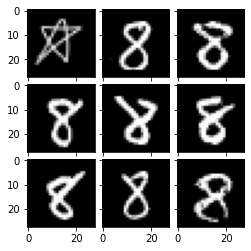

In [27]:
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

imgs = (PILImage.create(m[0][1]) for m in best_match_mnist(fingerprint_db, fps2, 9))

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# tSNE

Map all embeddings to a 2d plane to get an idea of how the data is clustered

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10003 samples in 0.000s...
[t-SNE] Computed neighbors for 10003 samples in 1.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10003
[t-SNE] Computed conditional probabilities for sample 2000 / 10003
[t-SNE] Computed conditional probabilities for sample 3000 / 10003
[t-SNE] Computed conditional probabilities for sample 4000 / 10003
[t-SNE] Computed conditional probabilities for sample 5000 / 10003
[t-SNE] Computed conditional probabilities for sample 6000 / 10003
[t-SNE] Computed conditional probabilities for sample 7000 / 10003
[t-SNE] Computed conditional probabilities for sample 8000 / 10003
[t-SNE] Computed conditional probabilities for sample 9000 / 10003
[t-SNE] Computed conditional probabilities for sample 10000 / 10003
[t-SNE] Computed conditional probabilities for sample 10003 / 10003
[t-SNE] Mean sigma: 0.020139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.921059
[t-SNE] KL 

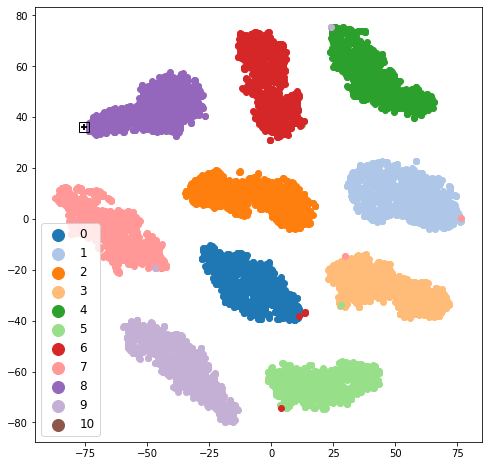

TSNE(init='random', learning_rate='auto', random_state=42, verbose=1)

In [28]:
def visualize(fingerprints_db, fingerprints_to_highlight = [], indices_to_highlight = []):
    l = list(fingerprint_db.values())
    fps = np.array(l + fingerprints_to_highlight)
    tsne = TSNE(2, init='random', learning_rate='auto', random_state = 42, verbose = 1)    
    tsne_proj = tsne.fit_transform(fps)
    
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    num_categories = 11

    for i in range(num_categories):
        matching_indices = [key for key, (val,_) in enumerate(fingerprint_db.keys()) if val == str(i)]
        plt.scatter(tsne_proj[matching_indices,0], tsne_proj[matching_indices,1], c = np.array(cmap(i)).reshape(1,4), label = i)
    ax.legend(fontsize='large', markerscale=2)
    
    # Highlight
    plt.scatter(tsne_proj[indices_to_highlight,0], tsne_proj[indices_to_highlight,1], marker = '+', c = 'k', label = 'highlight') 
    ixs_to_highlight = range(len(fps) - len(fingerprints_to_highlight),len(fps))
    (xs, ys) = (tsne_proj[ixs_to_highlight,0], tsne_proj[ixs_to_highlight,1])
    plt.scatter(xs, ys, marker = '+', c = 'k', label = 'highlight') 
    (min_x, min_y, max_x, max_y) = (min(xs), min(ys), max(xs), max(ys))
    min_x = min_x - 2
    min_y = min_y - 2
    width = max_x - min_x + 2
    height = max_y - min_y + 2
    rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    
    plt.savefig(model_name)
    plt.show()
    return tsne

fps = np.array(list(fingerprint_db.values()))
visualize(fps, fingerprints_to_highlight = [fps1, fps2])

epoch,train_loss,valid_loss,time
0,0.017188,0.028165,00:34
1,0.018652,0.030425,00:34
2,0.019052,0.029247,00:35
3,0.019880,0.029035,00:34
4,0.016921,0.029006,00:34
5,0.020704,0.027825,00:33
6,0.010647,0.028510,00:34
7,0.019289,0.029275,00:33
8,0.019621,0.028783,00:34
9,0.018136,0.030531,00:34


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10003 samples in 0.001s...
[t-SNE] Computed neighbors for 10003 samples in 1.717s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10003
[t-SNE] Computed conditional probabilities for sample 2000 / 10003
[t-SNE] Computed conditional probabilities for sample 3000 / 10003
[t-SNE] Computed conditional probabilities for sample 4000 / 10003
[t-SNE] Computed conditional probabilities for sample 5000 / 10003
[t-SNE] Computed conditional probabilities for sample 6000 / 10003
[t-SNE] Computed conditional probabilities for sample 7000 / 10003
[t-SNE] Computed conditional probabilities for sample 8000 / 10003
[t-SNE] Computed conditional probabilities for sample 9000 / 10003
[t-SNE] Computed conditional probabilities for sample 10000 / 10003
[t-SNE] Computed conditional probabilities for sample 10003 / 10003
[t-SNE] Mean sigma: 0.020139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.921059
[t-SNE] KL 

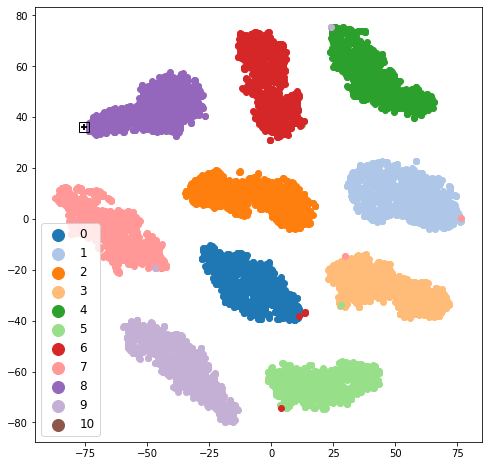

TSNE(init='random', learning_rate='auto', random_state=42, verbose=1)

In [29]:
def train_and_fingerprint(epochs, learning_rate, files_to_fingerprint) :
    if epochs>0:
        learn.fit_one_cycle(epochs,slice(learning_rate))
    fingerprints = fingerprint_all(files_to_fingerprint)
    return visualize(fingerprints, fingerprints_to_highlight = [fps1, fps2]) 

train_and_fingerprint(20, .0005, fnames)